/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
2025-01-05 18:27:48,158 - __main__ - INFO - Successfully fetched data for Hang Seng Index (^HSI)
2025-01-05 18:27:48,159 - __main__ - INFO - Successfully fetched data for Nikkei 225 (^N225)
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = ind

Index(['open', 'high', 'low', 'close', 'volume', 'adjclose', 'Ticker', 'Name'], dtype='object')


2025-01-05 18:27:54,556 - __main__ - WARNING - Not enough data for 90-day rolling correlation.


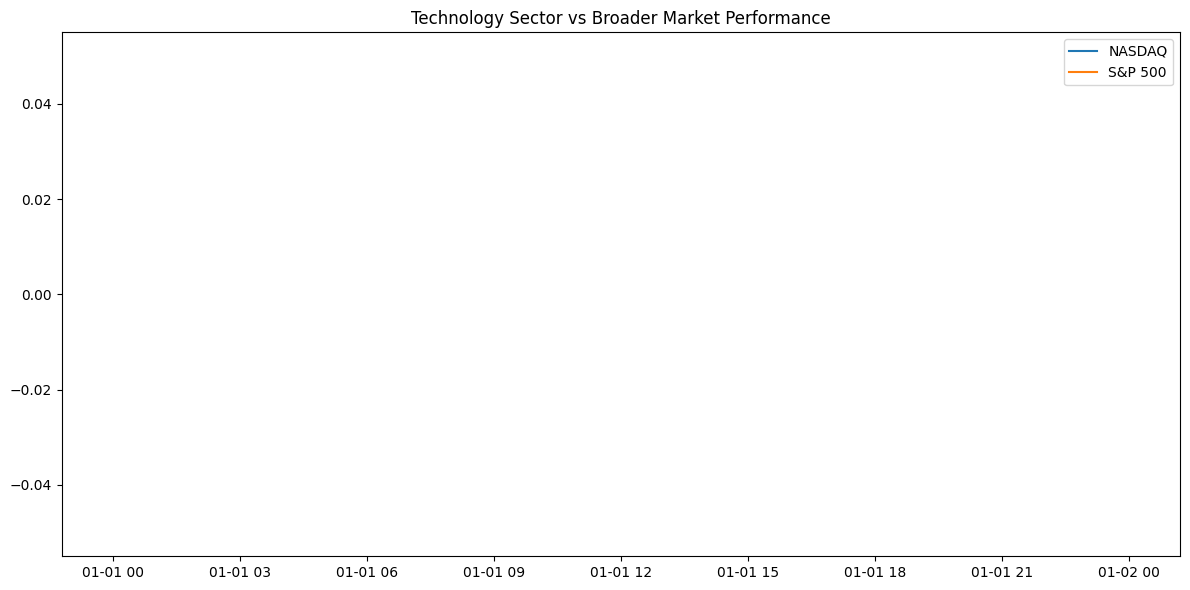

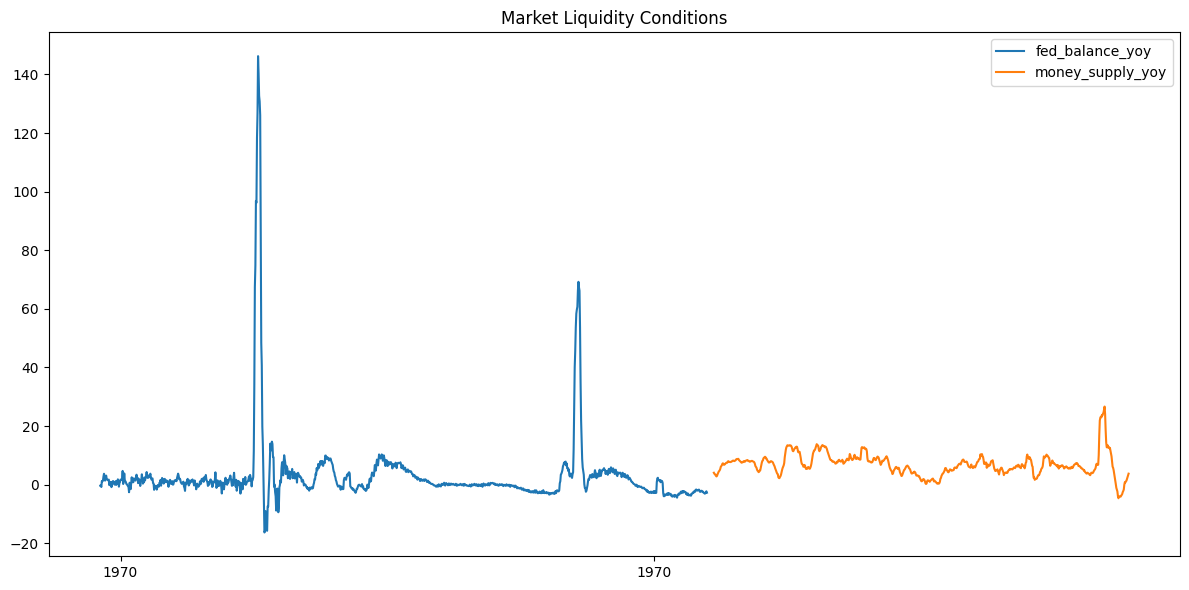

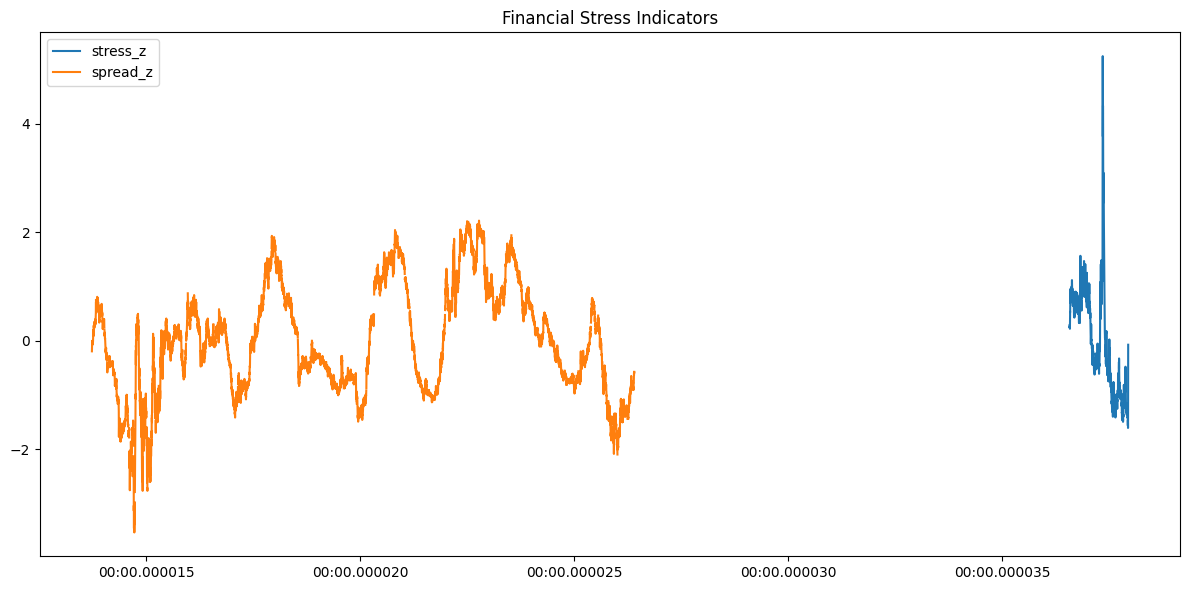


=== Macro Research Summary ===

Tech Sector Correlation (90-day): Data insufficient or missing

Liquidity Conditions:
Fed Balance Sheet YoY%: -2.8%
M2 Money Supply YoY%: 3.7%

Financial Stress:
Current Stress Z-Score: -0.07
Current Spread Z-Score: -0.58


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union
from datetime import datetime
from yahooquery import Ticker
from fredapi import Fred
import os
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from pathlib import Path
import logging
from concurrent.futures import ThreadPoolExecutor
from functools import partial

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

@dataclass
class MarketPeriod:
    """Data class for market period information."""
    name: str
    start_date: str
    end_date: str
    color: str

class DataCollector:
    """Handles data collection from various sources."""
    
    def __init__(self, fred_api_key: Optional[str] = None):
        self.fred_api_key = fred_api_key or os.getenv('FRED_API_KEY')
        if not self.fred_api_key:
            logger.warning("No FRED API key provided. FRED data collection will be disabled.")
        
        self.yahoo_tickers = {
            "^GSPC": "S&P 500",
            "^N225": "Nikkei 225",
            "^FTSE": "FTSE 100",
            "^HSI": "Hang Seng Index",
            "^IXIC": "NASDAQ Composite",
            "^TNX": "10-Year Treasury Yield",
            "^TYX": "30-Year Treasury Yield",
            "^FVX": "5-Year Treasury Yield",
            "^IRX": "13-Week Treasury Bill Yield",
            "^VIX": "CBOE Volatility Index",
            "BTC-USD": "Bitcoin_USD"
        }
        
        self.fred_series = {
            'GDP': 'Gross Domestic Product',
            'UNRATE': 'Unemployment Rate',
            'INDPRO': 'Industrial Production',
            'PAYEMS': 'Nonfarm Payrolls',
            'CIVPART': 'Labor Force Participation Rate',
            'CPIAUCSL': 'Consumer Price Index',
            'PPIACO': 'Producer Price Index',
            'PCEPILFE': 'Core PCE Price Index',
            'BOPGSTB': 'Trade Balance',
            'DTWEXBGS': 'US Dollar Index',
            'FEDFUNDS': 'Federal Funds Rate',
            'T10Y2Y': '10-Year Treasury Minus 2-Year Treasury Spread',
            'BAA10Y': "Moody's BAA Corporate Bond Yield Spread",
            'STLFSI': 'St. Louis Fed Financial Stress Index',
            'WALCL': 'Federal Reserve Balance Sheet',
            'M2SL': 'M2 Money Stock',
            'RRPONTSYD': 'Overnight Reverse Repo Agreements',
            'DFF': 'Effective Federal Funds Rate'
        }
    
    def collect_yahoo_data(self) -> pd.DataFrame:
        """Collect data from Yahoo Finance using parallel processing."""
        def fetch_ticker_data(ticker_info: Tuple[str, str]) -> Optional[pd.DataFrame]:
            ticker, name = ticker_info
            try:
                data = Ticker(ticker)
                history = data.history(period="max")
                if not history.empty:
                    history['Ticker'] = ticker
                    history['Name'] = name
                    logger.info(f"Successfully fetched data for {name} ({ticker})")
                    return history
                logger.warning(f"No data available for {name} ({ticker})")
                return None
            except Exception as e:
                logger.error(f"Error fetching data for {name} ({ticker}): {e}")
                return None
        
        with ThreadPoolExecutor() as executor:
            results = list(executor.map(fetch_ticker_data, self.yahoo_tickers.items()))
        
        valid_results = [df for df in results if df is not None]
        return pd.concat(valid_results, ignore_index=True) if valid_results else pd.DataFrame()
    
    def collect_fred_data(self) -> pd.DataFrame:
        """Collect data from FRED using parallel processing."""
        if not self.fred_api_key:
            logger.error("No FRED API key available")
            return pd.DataFrame()
        
        fred = Fred(api_key=self.fred_api_key)
        
        def fetch_fred_series(series_info: Tuple[str, str]) -> Optional[pd.DataFrame]:
            series_id, series_name = series_info
            try:
                series_data = fred.get_series(series_id)
                if series_data is not None and not series_data.empty:
                    df = pd.DataFrame(series_data, columns=['Value'])
                    df['Ticker'] = series_id
                    df['Name'] = series_name
                    logger.info(f"Successfully fetched data for {series_name} ({series_id})")
                    return df
                logger.warning(f"No data available for {series_name} ({series_id})")
                return None
            except Exception as e:
                logger.error(f"Error fetching data for {series_name} ({series_id}): {e}")
                return None
        
        with ThreadPoolExecutor() as executor:
            results = list(executor.map(fetch_fred_series, self.fred_series.items()))
        
        valid_results = [df for df in results if df is not None]
        return pd.concat(valid_results, ignore_index=True) if valid_results else pd.DataFrame()

class MarketAnalyzer:
    """Handles market analysis and calculations."""
    
    def __init__(self, market_data: pd.DataFrame, macro_data: pd.DataFrame):
        self.market_data = self._prepare_market_data(market_data)
        self.macro_data = self._prepare_macro_data(macro_data)
        self.periods = {
            "Post-2022 AI Tech Boom": MarketPeriod("Post-2022 AI Tech Boom", "2022-01-01", "2025-01-01", "lightblue"),
            "Cold War": MarketPeriod("Cold War", "1947-01-01", "1991-12-31", "lightgreen"),
            "2000 Tech Boom": MarketPeriod("2000 Tech Boom", "1995-01-01", "2002-12-31", "lightcoral")
        }
    
    @staticmethod
    def _prepare_market_data(df: pd.DataFrame) -> pd.DataFrame:
        """Prepare market data for analysis."""
        df = df.copy()
        df.index = pd.to_datetime(df.index)
        return df
    
    @staticmethod
    def _prepare_macro_data(df: pd.DataFrame) -> pd.DataFrame:
        """Prepare macro data for analysis."""
        df = df.copy()
        df.index = pd.to_datetime(df.index)
        return df
    
    def calculate_rolling_volatility(self, returns: pd.Series, window: int = 30) -> pd.Series:
        """Calculate rolling volatility."""
        return returns.rolling(window=window).std() * np.sqrt(252)
    
    def calculate_sharpe_ratio(self, returns: pd.Series, risk_free_rate: float = 0.01) -> float:
        """Calculate Sharpe ratio."""
        excess_returns = returns - risk_free_rate / 252
        return np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    
    def calculate_drawdowns(self, returns: pd.Series) -> float:
        """Calculate maximum drawdown."""
        cumulative_returns = (1 + returns).cumprod()
        peak = cumulative_returns.cummax()
        drawdown = (cumulative_returns - peak) / peak
        return drawdown.min()
    
    def analyze_tech_sector(self) -> Dict[str, Union[pd.Series, float]]:
        """Analyze technology sector performance."""
        if '^IXIC' not in self.market_data['Ticker'].values or '^GSPC' not in self.market_data['Ticker'].values:
            logger.error("Required market data (NASDAQ or S&P 500) is missing.")
            return {}
        
        tech_returns = self.market_data[self.market_data['Ticker'] == '^IXIC']['close']
        sp500_returns = self.market_data[self.market_data['Ticker'] == '^GSPC']['close']
        
        # Ensure that we have both time series aligned (e.g., dropping NA)
        data = pd.concat([tech_returns, sp500_returns], axis=1).dropna()
        tech_returns = data.iloc[:, 0]  # NASDAQ
        sp500_returns = data.iloc[:, 1]  # S&P 500
        
        if len(data) < 90:  # Not enough data for 90-day correlation
            logger.warning("Not enough data for 90-day rolling correlation.")
            return {
                'tech_returns': tech_returns,
                'sp500_returns': sp500_returns,
                'rolling_correlation': pd.Series(),
                'current_correlation': None
            }
        
        # Calculate rolling correlation (90 days window)
        rolling_corr = tech_returns.rolling(window=90).corr(sp500_returns)
        
        return {
            'tech_returns': tech_returns,
            'sp500_returns': sp500_returns,
            'rolling_correlation': rolling_corr,
            'current_correlation': rolling_corr.iloc[-1] if not rolling_corr.empty else None
        }

    
    def analyze_liquidity_conditions(self) -> Dict[str, pd.Series]:
        """Analyze market liquidity conditions."""
        fed_balance = self.macro_data.loc[self.macro_data['Ticker'] == 'WALCL', 'Value']
        money_supply = self.macro_data.loc[self.macro_data['Ticker'] == 'M2SL', 'Value']
        
        return {
            'fed_balance_yoy': fed_balance.pct_change(periods=12) * 100,
            'money_supply_yoy': money_supply.pct_change(periods=12) * 100
        }
    
    def analyze_stress_indicators(self) -> Dict[str, pd.Series]:
        """Analyze financial stress indicators."""
        stress_index = self.macro_data.loc[self.macro_data['Ticker'] == 'STLFSI', 'Value']
        yield_spread = self.macro_data.loc[self.macro_data['Ticker'] == 'T10Y2Y', 'Value']
        
        stress_z = (stress_index - stress_index.mean()) / stress_index.std()
        spread_z = (yield_spread - yield_spread.mean()) / yield_spread.std()
        
        return {
            'stress_z': stress_z,
            'spread_z': spread_z
        }

class Visualizer:
    """Handles data visualization."""
    
    def plot_market_comparison(self, data: Dict[str, pd.Series], title: str):
        """Plot market comparison."""
        plt.figure(figsize=(12, 6))
        for i, (name, series) in enumerate(data.items()):
            plt.plot(series.index, series, label=name)
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def plot_rolling_metrics(self, metrics: Dict[str, pd.Series], title: str):
        """Plot rolling metrics."""
        plt.figure(figsize=(12, 6))
        for i, (name, series) in enumerate(metrics.items()):
            plt.plot(series.index, series, label=name)
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

def main():
    """Main execution function."""
    # Initialize components
    data_collector = DataCollector()
    
    # Collect data
    yahoo_data = data_collector.collect_yahoo_data()
    fred_data = data_collector.collect_fred_data()

    print(yahoo_data.columns)
    
    # Save raw data
    yahoo_data.to_csv('data/yahoo_data.csv')
    fred_data.to_csv('data/fred_data.csv')
    
    # Initialize analyzer and visualizer
    analyzer = MarketAnalyzer(yahoo_data, fred_data)
    visualizer = Visualizer()
    
    # Perform analysis
    tech_analysis = analyzer.analyze_tech_sector()
    liquidity_analysis = analyzer.analyze_liquidity_conditions()
    stress_analysis = analyzer.analyze_stress_indicators()
    
    # Create visualizations
    visualizer.plot_market_comparison(
        {'NASDAQ': tech_analysis.get('tech_returns'), 'S&P 500': tech_analysis.get('sp500_returns')},
        'Technology Sector vs Broader Market Performance'
    )
    
    visualizer.plot_rolling_metrics(
        liquidity_analysis,
        'Market Liquidity Conditions'
    )
    
    visualizer.plot_rolling_metrics(
        stress_analysis,
        'Financial Stress Indicators'
    )
    
    # Generate summary report
    print("\n=== Macro Research Summary ===")
    
    # Safe check for current_correlation
    current_correlation = tech_analysis.get('current_correlation')
    if current_correlation is not None:
        print(f"\nTech Sector Correlation (90-day): {current_correlation:.2f}")
    else:
        print("\nTech Sector Correlation (90-day): Data insufficient or missing")
    
    print(f"\nLiquidity Conditions:")
    print(f"Fed Balance Sheet YoY%: {liquidity_analysis['fed_balance_yoy'].iloc[-1]:.1f}%")
    print(f"M2 Money Supply YoY%: {liquidity_analysis['money_supply_yoy'].iloc[-1]:.1f}%")
    
    print(f"\nFinancial Stress:")
    print(f"Current Stress Z-Score: {stress_analysis['stress_z'].iloc[-1]:.2f}")
    print(f"Current Spread Z-Score: {stress_analysis['spread_z'].iloc[-1]:.2f}")


if __name__ == "__main__":
    main()
